# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://compsci682-fa18.github.io/assignments2018/assignment1) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs682.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs682.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs682/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [6]:
from cs682.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [15]:
# Use the validation set to tune the learning rate and regularization strength

from cs682.classifiers.linear_classifier import LinearSVM

f1 = lambda x: 1*(10**x)
f2 = lambda x: 2.5*(10**x)
f3 = lambda x: 5*(10**x)

learning_rates = [f(e) for e in [-7, -6, -5, -4, -3] for f in (f1, f2, f3)]
regularization_strengths = [f(e) for e in [4, 5, 6] for f in (f1, f2, f3)]
batch_sizes = [250, 500, 750]
num_iterations = [250, 500, 1000, 2000]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################

for rate in learning_rates:
    for strength in regularization_strengths:
        for batch_size in batch_sizes:
            for num_iters in num_iterations:
                
                svm = LinearSVM()
                loss_history = svm.train(X_train_feats, 
                                         y_train,
                                         learning_rate=rate,
                                         reg=strength,
                                         num_iters=num_iters,
                                         batch_size=batch_size)

                yt_pred = svm.predict(X_train_feats)
                yt_acc = np.mean(y_train == yt_pred)
                yv_pred = svm.predict(X_val_feats)
                yv_acc = np.mean(y_val == yv_pred)

                results[(rate, strength, batch_size, num_iters)] = (yt_acc, yv_acc)

                if yv_acc > best_val:
                    best_val = yv_acc
                    best_svm = svm

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg, batch, num_iter in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg, batch, num_iter)]
    print('lr %e reg %e batch %d iters %d train accuracy: %f val accuracy: %f' % (
                lr, reg, batch, num_iter, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

/home/brendan/Desktop/school/grad/f19/cs682/assignment1/cs682/classifiers/linear_svm.py:144: RuntimeWarning: overflow encountered in multiply
  dW = X.T.dot(M) / num_train + 2 * reg * W
/home/brendan/Desktop/school/grad/f19/cs682/assignment1/cs682/classifiers/linear_svm.py:110: RuntimeWarning: invalid value encountered in subtract
  losses = all_scores - correct_class_scores + 1
/home/brendan/Desktop/school/grad/f19/cs682/assignment1/cs682/classifiers/linear_classifier.py:70: RuntimeWarning: invalid value encountered in subtract
  self.W -= learning_rate * grad
/home/brendan/Desktop/school/grad/f19/cs682/assignment1/cs682/classifiers/linear_svm.py:116: RuntimeWarning: invalid value encountered in greater
  margins = np.where(losses > 0, losses, 0)
/home/brendan/Desktop/school/grad/f19/cs682/assignment1/env/lib/python3.5/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


lr 1.000000e-07 reg 1.000000e+01 batch 250 iters 250 train accuracy: 0.106327 val accuracy: 0.102000
lr 1.000000e-07 reg 1.000000e+01 batch 250 iters 500 train accuracy: 0.123592 val accuracy: 0.117000
lr 1.000000e-07 reg 1.000000e+01 batch 250 iters 1000 train accuracy: 0.128510 val accuracy: 0.138000
lr 1.000000e-07 reg 1.000000e+01 batch 250 iters 2000 train accuracy: 0.091980 val accuracy: 0.102000
lr 1.000000e-07 reg 1.000000e+01 batch 500 iters 250 train accuracy: 0.124061 val accuracy: 0.143000
lr 1.000000e-07 reg 1.000000e+01 batch 500 iters 500 train accuracy: 0.116633 val accuracy: 0.121000
lr 1.000000e-07 reg 1.000000e+01 batch 500 iters 1000 train accuracy: 0.113265 val accuracy: 0.094000
lr 1.000000e-07 reg 1.000000e+01 batch 500 iters 2000 train accuracy: 0.126163 val accuracy: 0.137000
lr 1.000000e-07 reg 1.000000e+01 batch 750 iters 250 train accuracy: 0.076837 val accuracy: 0.088000
lr 1.000000e-07 reg 1.000000e+01 batch 750 iters 500 train accuracy: 0.101551 val accur

In [17]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.439


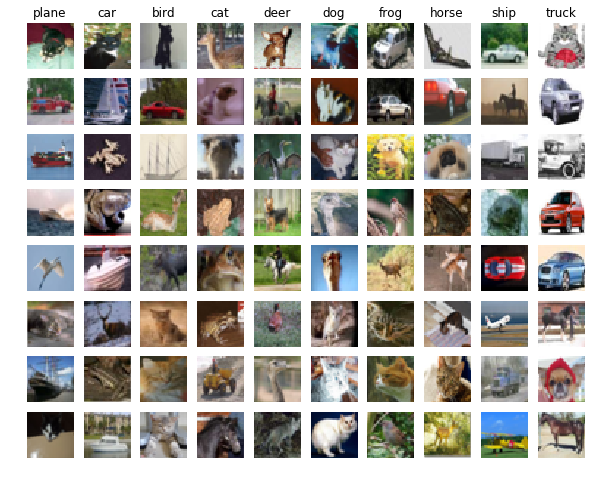

In [18]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

Some misclassification results are hard to interpret, but there are a number which can be reasonably explained -

1. The images in the "plane" column are all characterized by large proportions of the image being either blue or grey-blue, which suggests that one of the main characteristics of planes that the network learned was that they are often found in the sky.

2. Many of the images in the "deer" column are other animals with protruding appendages (a dog with big ears; a few birds with outstretched wings), suggesting that the neural network learned to classify deer by looking for antlers.

3. Half of the images in the "truck" column are cars, suggesting that the neural network learned *something* about how to classify four-wheeled passenger vehicles, but perhaps not quite enough to distinguish between sedans and pickup trucks.

4. Interestingly, half of the images in the "dog" column are cats, while only one of the images in the "cat" column is a dog, suggesting that the network learned that some characteristic of a dog is also *not* characteristic of a cat, but not necessarily any characteristic of either which would suggest the opposite. 

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [19]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [56]:
from cs682.classifiers.neural_net import TwoLayerNet

input_size = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################

def select_hyper_parameters():
    results = {}
    best_acc = -1
    best_net = None

    learning_rates = [5e-2, 1e-1, 2.5e-1, 5e-1, 1.0]
    regularization_strenghts = [1e-4, 2.5e-4, 5e-4, 1e-3, 2.5e-3]
    hidden_layer_sizes = [500, 750, 1000]
    batch_sizes = [50, 100]
    num_epochs = 4

    for rate in learning_rates:
        for strength in regularization_strenghts:
            for units in hidden_layer_sizes:
                for batch_size in batch_sizes:

                    num_iters = num_epochs * int(X_train_feats.shape[0] / batch_size)

                    net = TwoLayerNet(input_size, units, num_classes)

                    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                                      learning_rate=rate, 
                                      reg=strength,
                                      batch_size=batch_size,
                                      num_iters=num_iters)

                    val_acc = (net.predict(X_val_feats) == y_val).mean()
                    print('rate: %f, strength: %.7f, hidden units: %d, batch size: %d, acc: %f' % (rate,
                                                                                                   strength,
                                                                                                   units,
                                                                                                   batch_size,
                                                                                                   val_acc))

                    if val_acc > best_acc:
                        best_acc = val_acc
                        best_net = net

                    results[(rate, strength, units, batch_size, num_iters)] = (val_acc, stats)
                    
    return best_net, best_acc, results
                
# rate: 0.250000, strength: 0.0001000, hidden units: 1000, batch size: 100, acc: 0.607000
best_learning_rate = 2.5e-1
best_reg_strength = 1e-4
best_num_hidden_units = 1000
best_batch_size = 100
num_epochs = 4
perform_cross_validation = False


if perform_cross_validation is True:
    best_net, best_acc, results = select_hyper_parameters()
else:
    best_net = TwoLayerNet(input_size, best_num_hidden_units, num_classes)
    
    num_iters = num_epochs * int(X_train.shape[0] / best_batch_size)
    
    stats = net.train(X_train, y_train, X_val, y_val,
                      learning_rate=best_learning_rate,
                      reg=best_reg_strength,
                      batch_size=best_batch_size,
                      num_iters=num_iters)
    
    best_acc = (best_net.predict(X_val) == y_val).mean()
    
    print('rate: %f, strength: %.7f, hidden units: %d, batch size: %d, acc: %f' % (best_learning_rate,
                                                                                   best_reg_strength,
                                                                                   best_num_hidden_units,
                                                                                   best_batch_size,
                                                                                   best_acc))
    
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

rate: 0.050000, strength: 0.0001000, hidden units: 500, batch size: 50, acc: 0.544000
rate: 0.050000, strength: 0.0001000, hidden units: 500, batch size: 100, acc: 0.514000
rate: 0.050000, strength: 0.0001000, hidden units: 750, batch size: 50, acc: 0.549000
rate: 0.050000, strength: 0.0001000, hidden units: 750, batch size: 100, acc: 0.525000
rate: 0.050000, strength: 0.0001000, hidden units: 1000, batch size: 50, acc: 0.526000
rate: 0.050000, strength: 0.0001000, hidden units: 1000, batch size: 100, acc: 0.522000
rate: 0.050000, strength: 0.0002500, hidden units: 500, batch size: 50, acc: 0.539000
rate: 0.050000, strength: 0.0002500, hidden units: 500, batch size: 100, acc: 0.514000
rate: 0.050000, strength: 0.0002500, hidden units: 750, batch size: 50, acc: 0.537000
rate: 0.050000, strength: 0.0002500, hidden units: 750, batch size: 100, acc: 0.511000
rate: 0.050000, strength: 0.0002500, hidden units: 1000, batch size: 50, acc: 0.540000
rate: 0.050000, strength: 0.0002500, hidden un

In [57]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.575
